{% include toc title="In This Lesson" icon="file-text" %}

<div class='notice--success' markdown="1">

## <i class="fa fa-graduation-cap" aria-hidden="true"></i> Learning Objectives

After completing this lesson, you will be able to:

* Crop a raster dataset in `Python` using a vector extent object derived from a shapefile.
* Open a shapefile in `Python`.

## <i class="fa fa-check-square-o fa-2" aria-hidden="true"></i> What You Need

[<i class="fa fa-download" aria-hidden="true"></i> Download spatial-vector-lidar data subset (~172 MB)](https://ndownloader.figshare.com/files/12459464){:data-proofer-ignore='' .btn }

You will need a computer with internet access to complete this lesson. If you are following along online and not using our cloud environment:

[<i class="fa fa-download" aria-hidden="true"></i> Get data and software setup instructions here]({{site.url}}/workshops/gis-open-source-python/){:data-proofer-ignore='' .btn }

You will need the Python 3.x Anaconda distribution, git and bash to set things up.
</div>

In this lesson, you will learn how to crop a raster dataset in `Python`. 

## What Does Crop a Raster Mean?

Cropping (sometimes also referred to as clipping), is when you subset or make a dataset smaller, 
by removing all data outside of the crop area or spatial extent. In this case you have a large 
raster - but let's pretend that you only need to work with a smaller subset of the raster. 

You can use the `crop_extent` function to remove all of the data outside of your study area.
This is useful as it:

1. Makes the data smaller and 
2. Makes processing and plotting faster

In general when you can, it's often a good idea to crop your raster data!

To begin let's load the libraries that you will need in this lesson. 


## Load Libraries

### Be sure to set your working directory
`os.chdir("path-to-you-dir-here/earth-analytics/data")`

In [1]:
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping
import numpy as np
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import earthpy as et
import cartopy as cp
plt.ion()

os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))
# optional - turn off warnings
import warnings
warnings.filterwarnings('ignore')

## Open Raster and Vector Layers

Next, you will use `rio.open()` to open a raster layer. Open and plot the canopy height model (CHM) that you created in the previous lesson. Or you can use the CHM provided to you in the data directory here:

`data/spatial-vector-lidar/california/neon-soap-site/2013/lidar/SOAP_lidarCHM.tif`

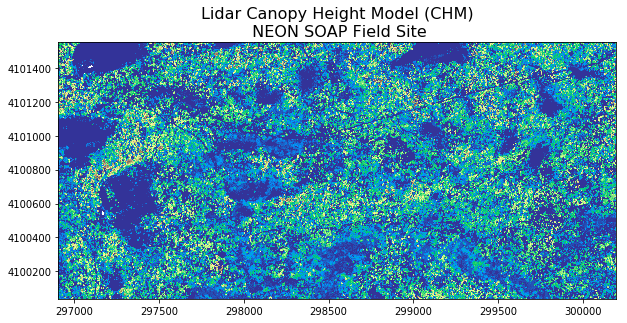

In [2]:
soap_chm_path = 'data/spatial-vector-lidar/california/neon-soap-site/2013/lidar/SOAP_lidarCHM.tif'
# open the lidar chm
with rio.open(soap_chm_path) as src:
    lidar_chm_im = src.read(masked = True)[0]
    extent = rio.plot.plotting_extent(src)
    soap_profile = src.profile

fig, ax = plt.subplots(figsize = (10,10))
show(lidar_chm_im, 
     cmap='terrain', 
     ax=ax,
      extent = extent)
ax.set_title("Lidar Canopy Height Model (CHM)\n NEON SOAP Field Site", 
             fontsize = 16);

## Open Vector Layer

Next, open up a vector layer that contains the crop extent that you want
to use to crop your data. To open a shapefile you use the `gpd.read_file()` function
from geopandas.

In [3]:
# open crop extent
crop_extent_soap = gpd.read_file('data/spatial-vector-lidar/california/neon-soap-site/vector_data/SOAP_crop2.shp')

Next, explore the coordinate reference system (CRS) of both of your datasets. 
Remember that in order to perform any analysis with these two datasets together,
they will need to be in the same CRS. 

In [4]:
print('crop extent crs: ', crop_extent_soap.crs)
print('lidar crs: ', soap_profile['crs'])

crop extent crs:  {'init': 'epsg:32611'}
lidar crs:  +init=epsg:32611


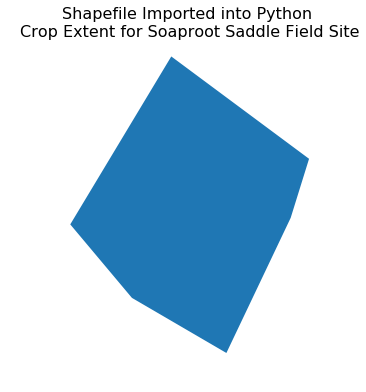

In [5]:
# plot the data
fig, ax = plt.subplots(figsize = (6, 6))
crop_extent_soap.plot(ax=ax)
ax.set_title("Shapefile Imported into Python \nCrop Extent for Soaproot Saddle Field Site", 
             fontsize = 16)
ax.set_axis_off();

In [6]:
# plotting with cartopy
# this is nice but not covered in this lesson so let's be consistent
# crs = cp.crs.epsg('32613')
# fig, ax = plt.subplots(subplot_kw={'projection': crs}) 
# ax.add_geometries(crop_extent['geometry'], crs=crs)
# ax.set(xlim=crop_extent.bounds[['minx', 'maxx']].values[0],
#        ylim=crop_extent.bounds[['miny', 'maxy']].values[0])

<figure>
    <a href="{{ site.url }}/images/courses/earth-analytics/spatial-data/spatial-extent.png">
    <img src="{{ site.url }}/images/courses/earth-analytics/spatial-data/spatial-extent.png" alt="The spatial extent of a shapefile the geographic edge or location that is the furthest north, south east and west."></a>
    <figcaption>The spatial extent of a shapefile represents the geographic "edge" or location that is the furthest north, south east and west. Thus is represents the overall geographic coverage of the spatial
    object. Image Source: Colin Williams, NEON.
    </figcaption>
</figure>

Now that you have imported the shapefile. Plot the two layers together to ensure the overlap each other. If the shapefile does not overlap the raster, then you can not use it to crop!

In [7]:
#bounds = lidar_chm.bounds
#bounds = [bounds.left, bounds.right, bounds.bottom, bounds.top]
#crop_extent.bounds

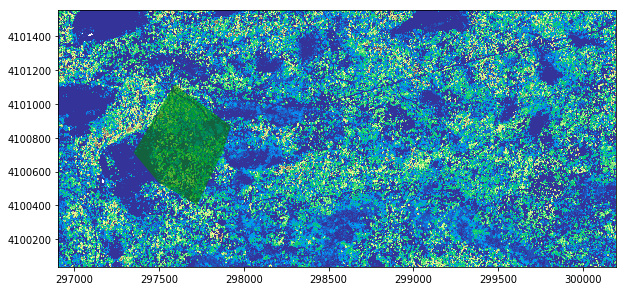

In [8]:
fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(lidar_chm_im, 
          cmap='terrain', 
          extent=extent)
crop_extent_soap.plot(ax=ax, alpha=.6, color='g');

In [9]:
#crop_bounds = crop_extent.total_bounds

In [10]:
# NOTE: you only need to use cartopy to use `add_geometries`.
# If you don't need to use that method, you can just use geopandas/vanilla matplotlib
# ax.add_geometries(crop_extent['geometry'], crs=cp.crs.PlateCarree())

In [11]:
# fig, ax = plt.subplots()
# im = ax.imshow(lidar_chm_im, 
#                cmap='terrain', 
#                extent=extent)
# ax.set(xlim=[crop_bounds[0], crop_bounds[2]], 
#        ylim=[crop_bounds[1], crop_bounds[3]])

# crop_extent.plot(ax=ax, linewidth=3, alpha=.5, color='green');

To crop the data,use the `mask` function in `rasterio`.

In [12]:
from rasterio.mask import mask
from shapely.geometry import mapping

In [13]:
with rio.open(soap_chm_path) as src:
    extent_geojson = mapping(crop_extent_soap['geometry'][0])
    lidar_chm_crop, crop_affine = mask(src, 
                                   shapes=[extent_geojson], 
                                   crop=True)
    # metadata for writing or exporting the data
    soap_lidar_meta = src.meta.copy()

In [44]:
# Update the metadata to have the new shape (x and y and affine information)
soap_lidar_meta.update({"driver": "GTiff",
                 "height": lidar_chm_crop.shape[0],
                 "width": lidar_chm_crop.shape[1],
                 "transform": crop_affine})

# generate an extent for the newly cropped object for plotting
cr_ext = rio.transform.array_bounds(soap_lidar_meta['height'], 
                                            soap_lidar_meta['width'], 
                                            soap_lidar_meta['transform'])

bound_order = [0,2,1,3]
cr_extent = [cr_ext[b] for b in bound_order]
cr_extent, crop_extent_soap.total_bounds

([297349.0, 298062.0, 4101114.0, 4101115.0],
 array([ 297349.82145413, 4100402.84616318,  297923.2856659 ,
        4101114.9500745 ]))

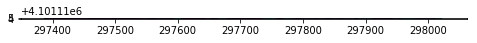

In [43]:
# mask the nodata and plot the newly cropped raster layer
lidar_chm_crop_ma = np.ma.masked_equal(lidar_chm_crop[0], -9999.0) 
fig, ax = plt.subplots(figsize = (8,8))
ax.imshow(lidar_chm_crop_ma, extent = cr_extent)
#crop_extent_soap.plot(ax=ax, alpha=.6, color='g');
#ax.set_axis_off()


In [15]:
# crop_prof
# lidar

# # this is from the rio docs
# import fiona
# import rasterio
# from rasterio.tools.mask import mask

# with fiona.open("tests/data/box.shp", "r") as shapefile:
#     geoms = [feature["geometry"] for feature in shapefile]

# with rasterio.open("tests/data/RGB.byte.tif") as src:
#     out_image, out_transform = mask(src, geoms, crop=True)
#     out_meta = src.meta.copy()

# out_meta.update({"driver": "GTiff",
#                  "height": out_image.shape[1],
#                  "width": out_image.shape[2],
#                  "transform": out_transform})

# with rasterio.open("/tmp/masked.tif", "w", **out_meta) as dest:
#     dest.write(out_image)

In [16]:

# Save to disk so you can use the file later.
path_out = "data/spatial-vector-lidar/outputs/soap_lidar_chm_crop.tif"
with rio.open(path_out, 'w', **soap_lidar_meta) as ff:
    ff.write(lidar_chm_crop[0], 1)

<div class="notice--warning" markdown="1">

## <i class="fa fa-pencil-square-o" aria-hidden="true"></i> Optional Challenge: Crop the SJER Lidar Data 

Above your cropped the data for the SOaproot Saddle fieldsite. Crop the data using the same approach for the sjer field site located in this folder: `data/spatial-vector-lidar/california/neon-sjer-site`. 
</div>